# **Assignment 3 - Pattern Recogonition Course**

## Speech Emotion Recogonition

## Importing libraries

In [1]:
# General libraries
import os
import numpy as np
import pandas as pd

# Audio processing libraries
from math import nan
import librosa

# Machine learning libraries
from sklearn.model_selection import train_test_split
from IPython.display import Audio, display

# Deep learning libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch Lightning
import pytorch_lightning as pl

# TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader

### Checking if Cuda is available

In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Download the Dataset and Understand the Format (10 Points)
### a. We will use CREMA dataset that is available at the following link: 
https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en

#### Constants

In [3]:
'''
- SAD - sadness;
- ANG - angry;
- DIS - disgust;
- FEA - fear;
- HAP - happy;
- NEU - neutral.
'''
labels_map = {
    "SAD":0,
    "ANG":1,
    "DIS":2,
    "FEA":3,
    "HAP":4,
    "NEU":5
}
labels = ['SAD','ANG','DIS','FEA','HAP','NEU']
audios = []



#### Reading Audio files

In [4]:
# Read all the wave files
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        file = {}
        wav_file_name = str(os.path.join(dirname, filename))
        file['name'] = filename
        file['abs_path'] = wav_file_name
        # Get the emotion type from the name of the wave file
        real_label = wav_file_name.split('_')[2] # ANG SAD
        file['real_label'] = real_label # ANG/SAD/DIS/FEA...
        file['label'] = labels_map[real_label]
        # loading .wav file
        waveform, sample_rate = librosa.load(wav_file_name)
        file['sample_rate'] = sample_rate
        file['wav'] = waveform

        audios.append(file)

### b. Write your own function that loads an audio and listen to each of the classes you have and plot the waveform of the audio. 

The waveform of random class SAD


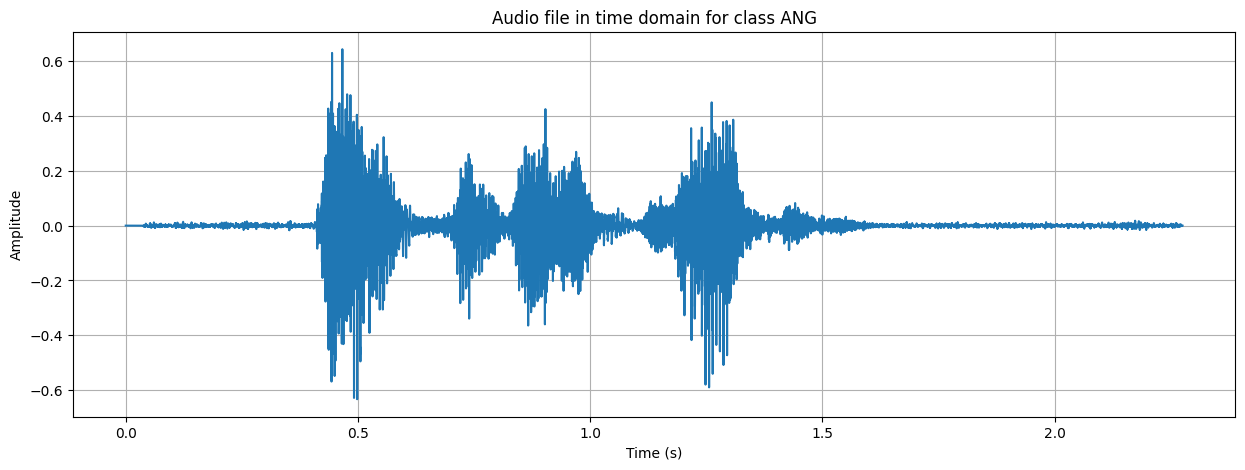

The waveform of random class ANG


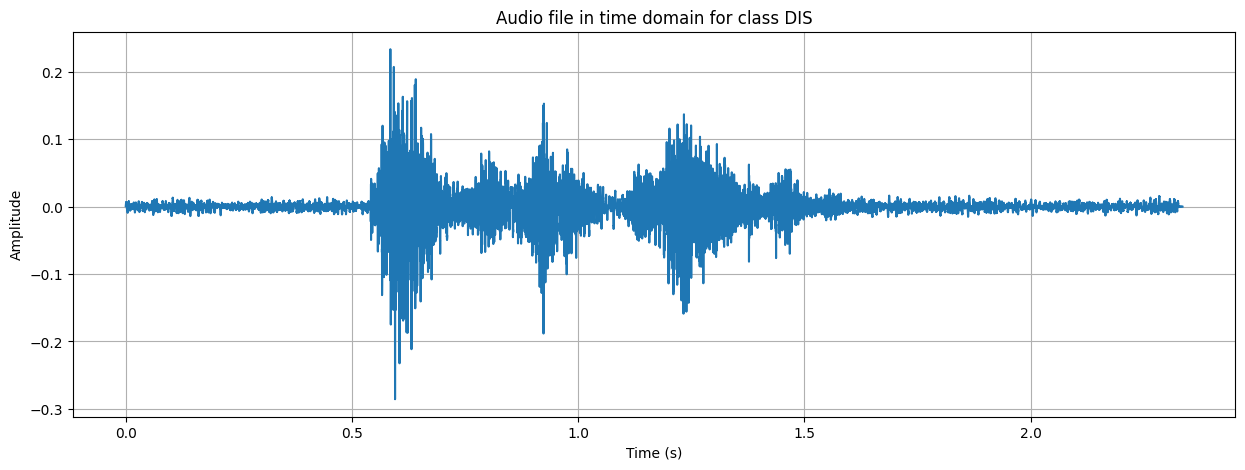

The waveform of random class DIS


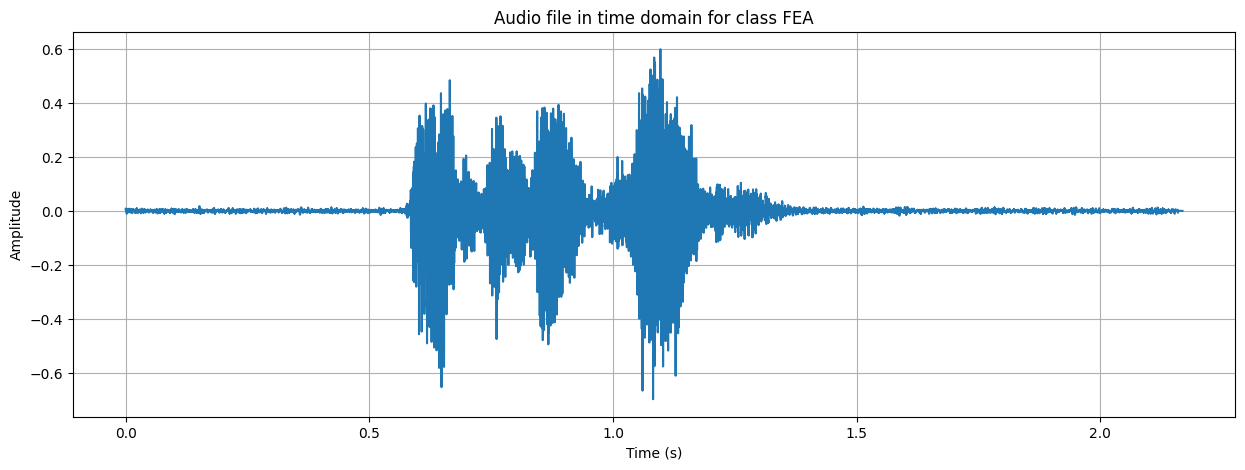

The waveform of random class FEA


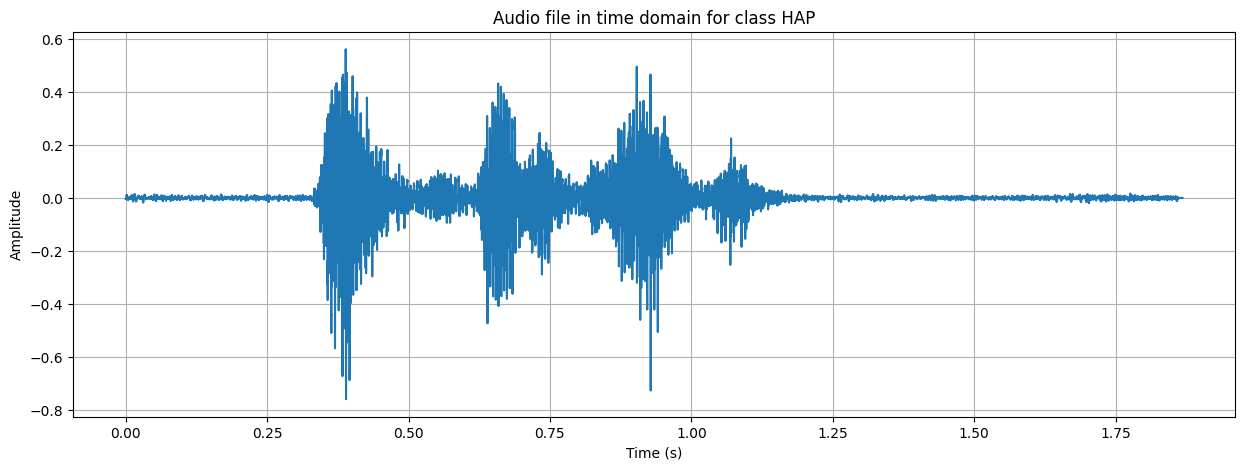

The waveform of random class HAP


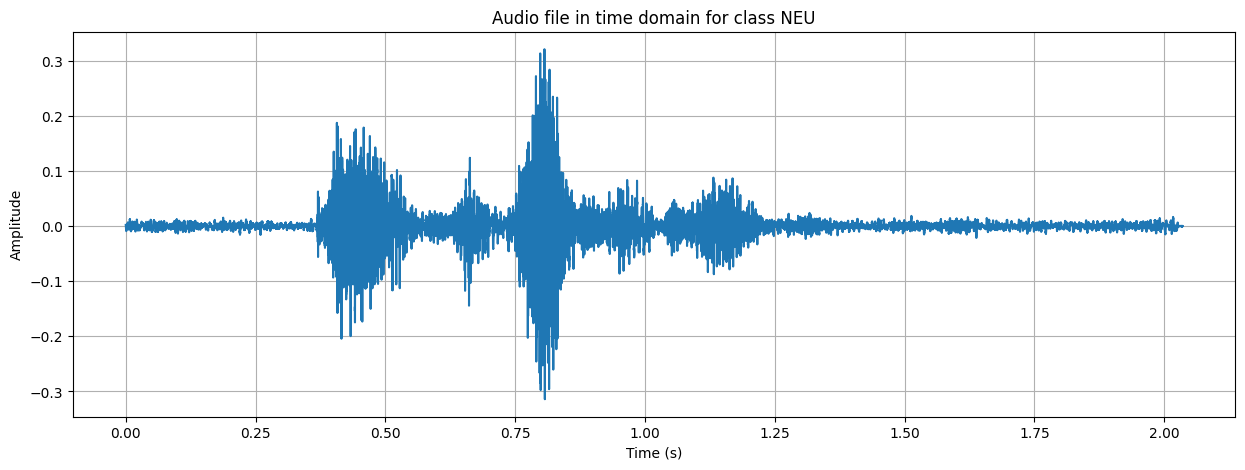

The waveform of random class NEU


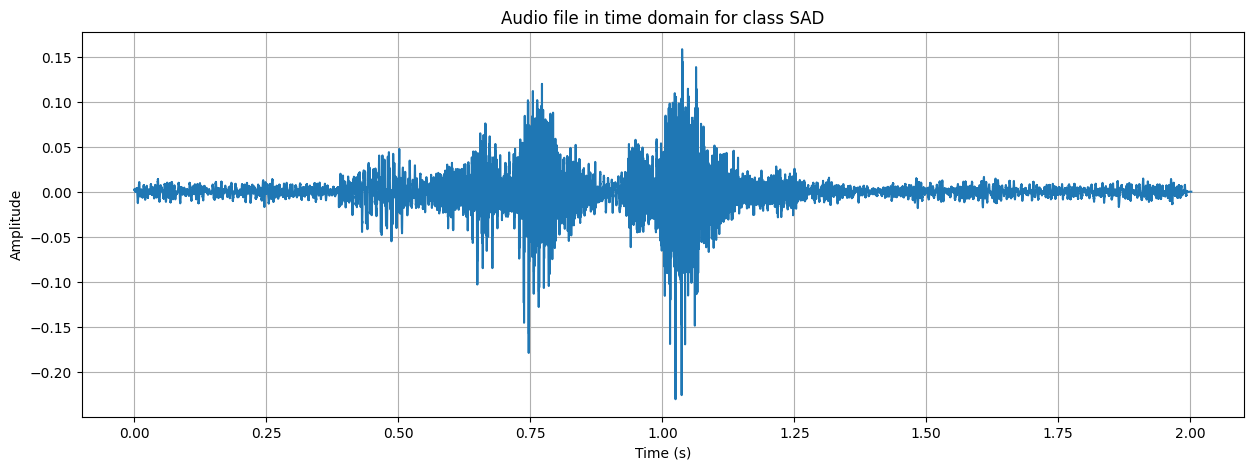

In [5]:
def plot_audio_time_domain(audio):
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, len(audio['wav'])/audio['sample_rate'], num=len(audio['wav'])), audio['wav'])
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'Audio file in time domain for class {audio["real_label"]}')
    plt.show()
    
features = list(labels_map.keys())
features = np.array(features)

random_picks = []
for feature in features:
    feature_indices = np.where(features == feature)
    random = np.random.choice(list(feature_indices)[0])
    random_picks.append(random)
    print("The waveform of random class {0}".format(feature))
    plot_audio_time_domain(audios[random])

#### Playing audios from different classes

In [6]:
for r in random_picks:
    print(f"Audio for class [{audios[r]['real_label']}]")
    display(Audio(data=audios[r]['wav'], rate = audios[r]['sample_rate'], autoplay=False))

Audio for class [ANG]


Audio for class [DIS]


Audio for class [FEA]


Audio for class [HAP]


Audio for class [NEU]


Audio for class [SAD]


## 2. Creating the Feature Space (30 Points) 
#### a. You can work on time domain, or you can work in frequency domain. There are multiple of features that can help improving the model:

In [8]:
# i. Zero crossing rate: The rate of sign-changes of the signal during the duration of a particular frame.
# ii. Energy: The sum of squares of the signal values, normalized by the respective frame length.
# calculate the zero crossing rate and energy for each frame
def calculate_zcr_energy(wav, frame_length, hop_length):
    # calculate the zero crossing rate
    zcr = librosa.feature.zero_crossing_rate(wav, frame_length=frame_length, hop_length=hop_length)[0]
    # calculate the energy normalised by the frame length
    energy = librosa.feature.rms(y=wav, frame_length=frame_length, hop_length=hop_length)[0]
    return zcr, energy

max_pad_len = 216
# assigning zcr and energy to each audio file
for audio in audios:
    # calculate the zero crossing rate and energy for each frame
    zcr, energy = calculate_zcr_energy(audio['wav'], frame_length=2048, hop_length=512)
    # pad the sequences to have same length
    pad_width = max_pad_len - zcr.shape[0]
    zcr = np.pad(zcr, pad_width=((0, pad_width)), mode='constant')
    energy = np.pad(energy, pad_width=((0, pad_width)), mode='constant')
    # convert to torch tensor
    audio['zcr'] = torch.tensor(zcr)
    # convert to torch tensor
    audio['energy'] = torch.tensor(energy)
    # add the size of the tensor

# normalize features using min-max normalization
def min_max_normalization(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    tensor = (tensor - min_val) / (max_val - min_val)
    return tensor

# # normalize the zcr and energy features
# for audio in audios:
#     audio['zcr'] = min_max_normalization(audio['zcr'])
#     audio['energy'] = min_max_normalization(audio['energy'])

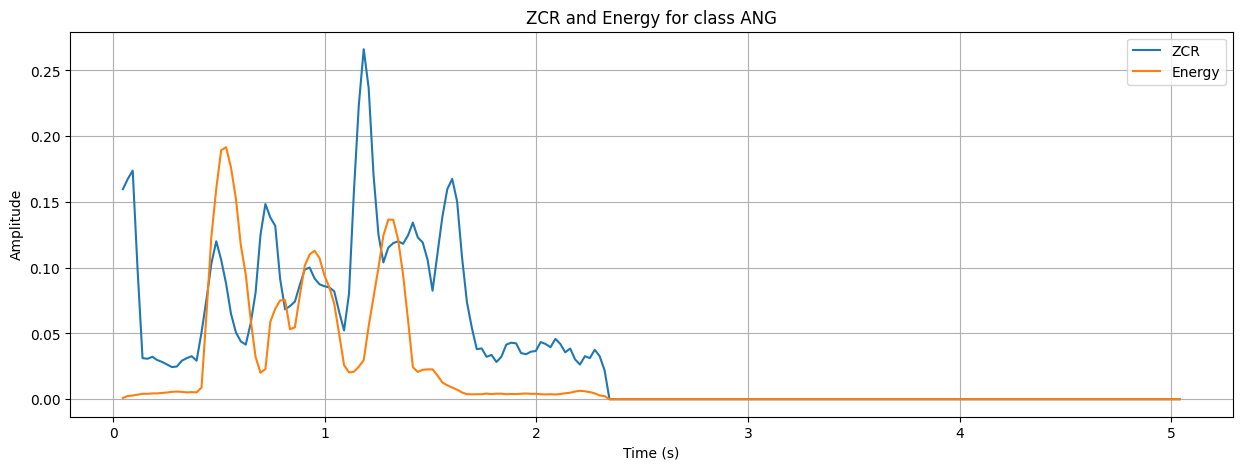

In [9]:
# plot the zero crossing rate and energy for each audio file
def plot_zcr_energy(audio):
    plt.figure(figsize=(15, 5))
    frames = range(len(audio['zcr']))
    t = librosa.frames_to_time(
        frames, sr=audio['sample_rate'], hop_length=512, n_fft=2048)
    plt.plot(t, audio['zcr'], label='ZCR')
    plt.plot(t, audio['energy'], label='Energy')
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f'ZCR and Energy for class {audio["real_label"]}')
    plt.legend()
    plt.show()

plot_zcr_energy(audios[0])


#### b. Convert the audio waveform to mel spectrogram and use this as the feature space.

In [10]:
# convert the audio files to mel-spectrogram
def convert_to_melspectrogram(audio, n_fft, hop_length, n_mels):
    # convert the audio waveform to spectrogram
    spectrogram = librosa.feature.melspectrogram(y=audio['wav'], sr=audio['sample_rate'], n_fft=n_fft, 
                                                 hop_length=hop_length, n_mels=n_mels)
    # convert to log scale
    logmel_spectrogram = librosa.power_to_db(spectrogram)
    return logmel_spectrogram

# assigning logmel_spectrogram to each audio file and save it to audio['mel_spectrogram']
# enter max padding length = 216
max_pad_len = 216
# use  librosa.feature.melspectrogram
for audio in audios:
    # convert the audio waveform to spectrogram
    mel_spectrogram = convert_to_melspectrogram(audio, n_fft=2048, hop_length=512, n_mels=128)
    # pad the spectrogram to have same size for all files
    mel_spectrogram = librosa.util.fix_length(data=mel_spectrogram, size=max_pad_len, axis=1)
    # convert to PyTorch tensor
    audio['mel_spectrogram'] = torch.from_numpy(mel_spectrogram).float()

print(audio['mel_spectrogram'].shape)


torch.Size([128, 216])


In [11]:
# get frequency and time domain for the spectrogram and save it to audio['time'] and audio['freq']
def get_spectrogram_details(audio):
    # get the frequency domain for the spectrogram
    freq = librosa.core.fft_frequencies(n_fft=2048)
    # get the time domain for the spectrogram
    hop_length = 512
    time = librosa.core.frames_to_time(np.arange(audio['mel_spectrogram'].shape[-1]), sr=audio['sample_rate'], hop_length=hop_length, n_fft=2048)
    return freq, time

for audio in audios:
    audio['freq'], audio['time'] = get_spectrogram_details(audio)
    # Fix the size of the time and frequency domain
    audio['freq'] = librosa.util.fix_length(data=audio['freq'], size=max_pad_len, axis=0)
    audio['time'] = librosa.util.fix_length(data=audio['time'], size=max_pad_len, axis=0)
    
    audio['freq'] = torch.from_numpy(audio['freq']).float()
    audio['time'] = torch.from_numpy(audio['time']).float()
    
print(audio['freq'].shape, audio['time'].shape)

torch.Size([216]) torch.Size([216])


## 3. Building Model 

### a. Split the data into 70% training and validation and 30% testing.
### b. Use 5% of the training and validation data for validation.


In [12]:
# assuming 'audios' is the list of dictionaries containing your data
features = [audio['label'] for audio in audios]

# split data into training and testing sets, stratifying by labels
x_train, x_test, y_train, y_test = train_test_split(audios, features, test_size=0.3, random_state=42, stratify=features)

# split training and validation sets, stratifying by labels
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=42,stratify=y_train)

print("Size of training data:", len(x_train))
print("Size of testing data:", len(x_val))
print("Size of validating data:", len(x_test))

Size of training data: 4948
Size of testing data: 261
Size of validating data: 2233


#### 2D Model

In [ ]:
def AudioDataLoader(x, y, shuffle, num_workers=None):
    processed_data = []
    for audio in x:
        processed_data.append(audio['mel_spectrogram'])
    inputs = torch.stack(processed_data, axis=0).unsqueeze(1)
    labels = torch.tensor(y)
    dataset = TensorDataset(inputs, labels)
    if(num_workers is None):
        dataloader = DataLoader(dataset, shuffle=shuffle)
    else:
        dataloader = DataLoader(dataset, num_workers=num_workers, shuffle=shuffle)
    return dataloader
    

In [ ]:
class LightningModel(pl.LightningModule):

    def __init__(self, **params):
        # Setting up the hyperparameters
        self.learning_rate = params['learning_rate']
        self.max_epochs = params['max_epochs']
        
        super().__init__()
        # convolutional layer parameters
        # first conv layer
        self.conv1 = torch.nn.Conv2d(1, 512, kernel_size=5, stride=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=5, stride=2)
        
        # second conv layer
        self.conv2 = torch.nn.Conv2d(512, 512, kernel_size=5, stride=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=5, stride=2)

        # third conv layer
        self.conv3 = torch.nn.Conv2d(512, 128, kernel_size=5, stride=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=5, stride=2)

        # fully connected layers
        self.fc1 = torch.nn.Linear(23040, 265)
        self.relu4 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(265, 6)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        #print(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def train_dataloader(self):
        # print("train_dataloader")
        return AudioDataLoader(x_train, y_train, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        return AudioDataLoader(x_val, y_val, shuffle=False, num_workers=4)
    
    def test_dataloader(self):  
        return AudioDataLoader(x_test, y_test, shuffle=False, num_workers=4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # print("y_hat", y_hat)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)
        return loss
    
    def save_model(self):
        torch.save(self.state_dict(), 'model.pt')
        
    def load_model(self):
        self.load_state_dict(torch.load('model.pt')) 
        

#### Model Training

In [ ]:
# Training the model
params = {'learning_rate': 1e-6, 'max_epochs': 1}
model = LightningModel(**params)
trainer = pl.Trainer(max_epochs=params['max_epochs'])

# tune the model for best learning rate
tuner = pl.tuner.tuning.Tuner(trainer)
lr_finder =tuner.lr_find(model)
new_lr = lr_finder.suggestion()
# model.hparams.learning_rate = new_lr
print(f"New learning rate suggested from lr finder: {new_lr}")


# train the model
trainer.fit(model)
# save the model
model.save_model()


#### Model validation and testing

In [ ]:
model.load_model()
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model)
model.save_model()

In [ ]:
# validate the model
trainer.validate(model, AudioDataLoader(x_val, y_val, shuffle=False, num_workers=4))
# test the model
trainer.test(model, AudioDataLoader(x_test, y_test, shuffle=False, num_workers=4))

#### Model Evaluation

In [13]:
def evaluate(model, test_loader):
    # change the model to cuda
    model.cuda()
    # set the model to evaluation mode
    y_pred = []
    y_true = []
    for i, (x, y) in enumerate(test_loader):
        x = x.cuda()
        y = y.cuda()
        y_hat = model(x)
        y_hat = torch.argmax(y_hat, dim=1)
        y_pred.extend(y_hat.cpu().tolist())
        y_true.extend(y.cpu().tolist())
    # print classification report
    print(classification_report(y_true, y_pred, zero_division=0))
    # plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
# create a test loader
test_loader = AudioDataLoader(x_test, y_test, shuffle=False, num_workers=4)
evaluate(model, test_loader)


### 1D Model

In [14]:
def EnergyDataLoader(x, y, num_workers, shuffle):
    processed_data = []
    for audio in x:
        processed_data.append(audio['energy'])
    inputs = torch.stack(processed_data, axis=0).unsqueeze(1)
    labels = torch.tensor(y)
    # print first 10 inputs and labels
    dataset = TensorDataset(inputs, labels)
    dataloader = DataLoader(dataset, num_workers=num_workers, shuffle=shuffle)
    return dataloader


In [33]:
class EnergyLightningModel(pl.LightningModule):

    def __init__(self, **params):
        # Setting up the hyperparameters
        self.learning_rate = params['learning_rate']
        self.max_epochs = params['max_epochs']

        super().__init__()
        
        # defining the model architecture
        # classifying 6 classes of audio data based on the frequency domain 1d convolutional neural network
        # input shape: (1, 216)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        # output shape: (16, 216)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # output shape: (16, 108)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # output shape: (32, 108)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # output shape: (32, 54)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # output shape: (64, 54)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        # output shape: (64, 27)
        self.fc1 = nn.Linear(64*27, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 6)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        # Input type (torch.cuda.DoubleTensor) and weight type (torch.cuda.FloatTensor) should be the same
        x = x.type(torch.cuda.FloatTensor)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.softmax(x)
        # print("x", x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return EnergyDataLoader(x_train, y_train, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return EnergyDataLoader(x_val, y_val, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return EnergyDataLoader(x_test, y_test, shuffle=False, num_workers=4)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # print("y_hat", y_hat)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def save_model(self):
        torch.save(self.state_dict(), 'model_1d.pt')

    def load_model(self):
        self.load_state_dict(torch.load('model_1d.pt'))


In [34]:
# Training the model
params = {'learning_rate': 0.01, 'max_epochs': 1}
model = EnergyLightningModel(**params)
trainer = pl.Trainer(max_epochs=params['max_epochs'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [35]:
# Tuning the model
tuner = pl.tuner.tuning.Tuner(trainer)
lr_finder = tuner.lr_find(model, min_lr=1e-5, max_lr=1e-2)
new_lr = lr_finder.suggestion()
print("new_lr", new_lr)
model.hparams.learning_rate = new_lr

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 282.26it/s]
Learning rate set to 0.00933254300796991
Restoring states from the checkpoint path at d:\Engineering\Pattern Recognition\Assignments\Assignment 3\speech-emotion-recognition\.lr_find_667fc6fe-dbe3-4ef8-bbb0-3d1581923517.ckpt
Restored all states from the checkpoint at d:\Engineering\Pattern Recognition\Assignments\Assignment 3\speech-emotion-recognition\.lr_find_667fc6fe-dbe3-4ef8-bbb0-3d1581923517.ckpt


new_lr 0.00933254300796991


In [28]:
# train the model
trainer.fit(model)
# save the model
model.save_model()


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type      | Params
---------------------------------------
0  | conv1   | Conv1d    | 64    
1  | relu1   | ReLU      | 0     
2  | pool1   | MaxPool1d | 0     
3  | conv2   | Conv1d    | 1.6 K 
4  | relu2   | ReLU      | 0     
5  | pool2   | MaxPool1d | 0     
6  | conv3   | Conv1d    | 6.2 K 
7  | relu3   | ReLU      | 0     
8  | pool3   | MaxPool1d | 0     
9  | fc1     | Linear    | 221 K 
10 | relu4   | ReLU      | 0     
11 | fc2     | Linear    | 774   
12 | softmax | Softmax   | 0     
---------------------------------------
229 K     Trainable params

Epoch 0: 100%|██████████| 4948/4948 [00:26<00:00, 187.57it/s, v_num=33]     

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 4948/4948 [00:26<00:00, 187.50it/s, v_num=33]


In [29]:
model = EnergyLightningModel(**params)
# load the model
model.load_model()
# run more epochs on the loaded model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model)
# save the model
model.save_model()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type      | Params
---------------------------------------
0  | conv1   | Conv1d    | 64    
1  | relu1   | ReLU      | 0     
2  | pool1   | MaxPool1d | 0     
3  | conv2   | Conv1d    | 1.6 K 
4  | relu2   | ReLU      | 0     
5  | pool2   | MaxPool1d | 0     
6  | conv3   | Conv1d    | 6.2 K 
7  | relu3   | ReLU      | 0     
8  | pool3   | MaxPool1d | 0     
9  | fc1     | Linear    | 221 K 
10 | relu4   | R

learning_rate 1
Epoch 7:  13%|█▎        | 651/4948 [00:04<00:30, 138.89it/s, v_num=34]      

c:\Users\Zyad\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


RuntimeError: File model_1d.pt cannot be opened.

In [23]:
# validate the model
trainer.validate(model, EnergyDataLoader(
    x_val, y_val, shuffle=False, num_workers=4))
# test the model
trainer.test(model, EnergyDataLoader(
    x_test, y_test, shuffle=False, num_workers=4))


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 261/261 [00:00<00:00, 526.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.6814680099487305     │
└───────────────────────────┴───────────────────────────┘

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2233/2233 [00:04<00:00, 518.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     1.656829833984375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.656829833984375}]

              precision    recall  f1-score   support

           0       0.37      0.84      0.51       382
           1       0.67      0.48      0.56       381
           2       0.32      0.20      0.25       381
           3       0.37      0.08      0.13       382
           4       0.40      0.22      0.28       381
           5       0.24      0.40      0.30       326

    accuracy                           0.37      2233
   macro avg       0.40      0.37      0.34      2233
weighted avg       0.40      0.37      0.34      2233



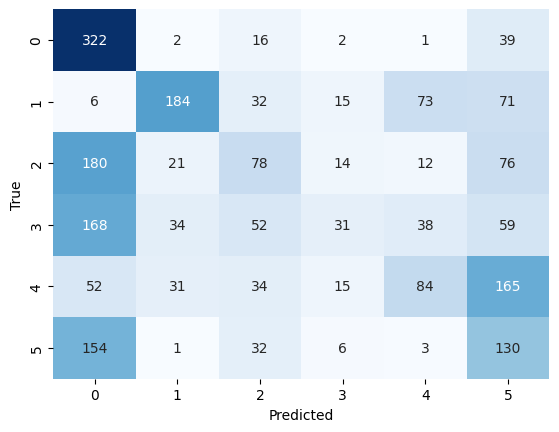

In [24]:
# evaluate the model
evaluate(model, model.test_dataloader())


In [ ]:
import torch
# clear the GPU memory
torch.cuda.empty_cache()